This script is designed to compare two types of neural network language models to understand how residual connections affect training and gradient flow in deep neural networks. Residual connections are a technique used to help train deeper networks more effectively.

The script starts by preparing the training environment, including setting up the device (CPU or GPU), initializing a random seed for consistency in results, and configuring data loaders for handling the training, validation, and testing datasets.

Key components of the script are:

1. **Vocabulary and Dataset Creation**: It uses a class (`WikiText2VocabBuilder`) to build a vocabulary from a text corpus and a dataset (`WikiText2Dataset`) suitable for language modeling.

2. **Model Definition**: Two versions of the `LanguageModel` class are defined - one with residual connections and one without. These models consist of layers like embedding, Linear, ReLU, and LayerNorm. In the model with residual connections, certain layers are skipped during the feed-forward process to facilitate the flow of gradients.

3. **Training Process**: The `train_language_model` function trains the models. It uses a specific number of training steps, a loss function (negative log likelihood), and an optimizer (Adam) with an exponentially decaying learning rate. The function also records the loss and a unique gradient statistic to understand the training dynamics.

4. **Model Training and Analysis**: Two instances of the language model (one with and one without residual connections) are created and trained. The training process captures data like loss and gradient statistics, which are then used for comparative analysis.

5. **Visualization**: The script generates plots to visually compare the loss trajectories and gradient distributions between the two models. This helps in understanding how the gradients behave in each model and the overall impact of residual connections on training deeper networks.





Import necessary libraries.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import defaultdict, Counter
import string
import math
import sys
import logging
from datetime import datetime
import yaml
import json
import string
import math
import sys
import logging
from datetime import datetime
import yaml




---

The code cell below loads configuration parameters from a YAML file, which include file paths for the training, validation, and testing datasets, minimum word frequency for vocabulary filtering, and context size for the neural network. Runtime settings such as data shuffling, number of workers, and batch size are defined, along with experiment specifications such as the number of epochs and various hyperparameters that determine the network's learning rate, decay, and architecture. It is noteworthy that the number of layers is set to 90. All information is in the corresponding yaml file.

---

In [ ]:
with open("deepResidualsConfig.yaml", 'r') as ymlfile:
    config = yaml.safe_load(ymlfile)

training_data_corpus_path = config['data']['training_data_corpus_path']
validation_data_corpus_path = config['data']['validation_data_corpus_path']
test_data_corpus_path = config['data']['test_data_corpus_path']
min_freq = config['data']['min_freq']
context_size = config['data']['context_size']

shuffle = config['runtime']['shuffle']
num_workers = config['runtime']['num_workers']
batch_size = config['runtime']['batch_size']
config_device = config['runtime']['device']


total_epochs = config['experiment']['total_epochs']
lr_start = config['hyperparameters']['lr_start']
lr_end = lr_start * config['hyperparameters']['reduction_factor']
weight_decay = config['hyperparameters']['weight_decay']
reduction_factor = config['hyperparameters']['reduction_factor']
numberOfLayers = config['hyperparameters']['numberOfLayers'] # Number of hidden layers
embed_size = config['hyperparameters']['embed_size']  # The embedding size of the words
hidden_size = config['hyperparameters']['hidden_size'] # The hidden size of the neural network



---

The code cell below defines the `WikiText2VocabBuilder` class, which initializes a vocabulary from a given corpus. It reads the corpus, preprocesses the text to clean and tokenize sentences, and counts word frequencies, excluding headers and managing special tokens. The class builds a word index and index-to-word mapping, ensuring that only words above a specified frequency threshold are included in the vocabulary.

---

In [ ]:
class WikiText2VocabBuilder:
    def _new_index(self):
        return len(self.word2index)

    def __init__(self, corpus_path, min_freq):
        self.corpus_path = corpus_path
        self.min_freq = min_freq
        self.word2index = defaultdict(self._new_index)
        self.index2word = {}
        self.word_freqs = Counter()
        self.cleaned_sentences = []

        self.START_TOKEN = "<s>"
        self.END_TOKEN = "</s>"
        self.UNK_TOKEN = "<unk>"
        self.hyphentoken = "hyphentoken"
        self.numericalcommatoken = "numericalcommatoken"

        self._initialize_special_tokens()
        self._load_and_preprocess()

    def _initialize_special_tokens(self):
        self.word2index[self.START_TOKEN] = 0
        self.word2index[self.END_TOKEN] = 1
        self.word2index[self.UNK_TOKEN] = 2
        self.word2index[self.hyphentoken] = 3
        self.word2index[self.numericalcommatoken] = 4

        self.index2word[0] = self.START_TOKEN
        self.index2word[1] = self.END_TOKEN
        self.index2word[2] = self.UNK_TOKEN
        self.index2word[3] = self.hyphentoken
        self.index2word[4] = self.numericalcommatoken


    def clean_and_tokenize(self, corpus):
        corpus = corpus.lower()  # Convert to lowercase
        sentences = sent_tokenize(corpus)
        cleaned_sentences = []
        for sentence in sentences:
            sentence = sentence.strip()  # Remove unnecessary whitespaces
            if not (sentence.startswith('=') or sentence.endswith('=')):  # Exclude headers
                sentence = sentence.replace('<unk>', 'unknowntoken')
                sentence = sentence.replace('@-@', 'hyphentoken')
                sentence = sentence.replace('@,@', 'numericalcommatoken')
                cleaned_sentences.append(sentence)
        return cleaned_sentences

    def _load_and_preprocess(self):
        with open(self.corpus_path, 'r') as f:
            corpus = f.read()

        # Split the text into sentences using NLTK
        self.cleaned_sentences = self.clean_and_tokenize(corpus)
        # Count word frequencies
        for sentence in self.cleaned_sentences:
            words = word_tokenize(sentence)
            for word in words:
                word = word.lower()
                self.word_freqs[word] += 1

        # Build the vocabulary using only words that meet the frequency threshold
        for word, freq in self.word_freqs.items():
            if freq >= self.min_freq:
                index = self.word2index[word]
                self.index2word[index] = word

    def vocab_size(self):
        return len(self.word2index)




---

The `WikiText2Dataset` class, inheriting from PyTorch's `Dataset`, is prepared to create a dataset for language modeling. It uses a preprocessor object to obtain cleaned sentences and a vocabulary index. The dataset is built by tokenizing these sentences and generating input-output pairs based on the context size. Methods are included to access the dataset length, retrieve specific items, sample random instances for inspection, and get the context size used during initialization.

---

In [ ]:
class WikiText2Dataset(Dataset):
    def __init__(self, preprocessor, context_size):
        super(WikiText2Dataset, self).__init__()

        self.context_size = context_size

        # We already have cleaned sentences in the preprocessor
        self.sentences = preprocessor.cleaned_sentences
        self.word2index = preprocessor.word2index
        self.index2word = preprocessor.index2word
        self.word_freqs = preprocessor.word_freqs
        self.START_TOKEN = preprocessor.START_TOKEN
        self.END_TOKEN = preprocessor.END_TOKEN
        self.UNK_TOKEN = preprocessor.UNK_TOKEN
        self.hyphentoken = preprocessor.hyphentoken
        self.numericalcommatoken = preprocessor.numericalcommatoken


        self.X, self.Y = self._build_dataset()

    def _build_dataset(self):
        X, Y = [], []

        for sentence in self.sentences:
            words = word_tokenize(sentence)
            if not words:
                continue
            if words[-1] in string.punctuation:
                words[-1] = self.END_TOKEN
            else:
                words.append(self.END_TOKEN)

            context = [0] * self.context_size
            for i, word in enumerate(words):

                if word in self.word2index and word not in ['unknowntoken', 'hyphentoken', 'numericalcommatoken']:
                    index = self.word2index[word]
                elif word == 'unknowntoken':
                    index = self.word2index[self.UNK_TOKEN]
                elif word == 'hyphentoken':
                    index = self.word2index[self.hyphentoken]
                elif word == 'numericalcommatoken':
                   index = self.word2index[self.numericalcommatoken]
                else:
                    index = self.word2index[self.UNK_TOKEN]
                X.append(context)
                Y.append(index)
                context = context[1:] + [index]

        return torch.tensor(X), torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def sample(self, num_samples):
        for _ in range(num_samples):
            idx = torch.randint(0, len(self), (1,)).item()
            context, target = self.X[idx], self.Y[idx]
            context_words = [self.index2word[i.item()] for i in context]
            target_word = self.index2word[target.item()]
            print(" ".join(context_words), "------>", target_word)

    def get_context_size(self):
        return self.context_size



---

The code cell below initializes a `WikiText2VocabBuilder` with a specified corpus path and minimum frequency, then creates instances of the `WikiText2Dataset` for training, validation, and testing. These instances share the same preprocessed vocabulary and context size.

---

In [ ]:
train_vocabBuilder =  WikiText2VocabBuilder(corpus_path = training_data_corpus_path, min_freq=min_freq)

train_dataset = WikiText2Dataset(train_vocabBuilder, context_size = context_size)
valid_dataset = WikiText2Dataset(train_vocabBuilder, context_size = context_size)
test_dataset = WikiText2Dataset(train_vocabBuilder, context_size = context_size)


---

The code cell below sets up `DataLoader` instances for the training, validation, and testing datasets, configuring each with parameters for batch size, shuffling, and parallel data loading.

---

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)



---

Within the code cell, the `LanguageModel` class is constructed to allow a comparative analysis of model performance with residual connections either activated or deactivated. The model is equipped with custom-implemented Linear, ReLU, and LayerNorm layers, which are designed to expose the 'out' variable for capturing layer activations and gradients. Residual connections, when enabled, are set to skip from the embedding to the corresponding hidden layer, and from each hidden layer directly to the output layer, bypassing only one layer at a time. This setup is intended for experimentation, enabling a clear observation of the impact of residual connections on the learning process in a neural network.

---

In [ ]:
class Linear(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Linear, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim))
        self.bias = nn.Parameter(torch.Tensor(self.output_dim))
        for param in self.parameters():
            param.requires_grad = True

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_normal_(self.weight, mode='fan_in', nonlinearity='relu')
        nn.init.constant_(self.bias, 0)

    def forward(self, x):
        self.out = torch.matmul(x, self.weight) + self.bias
        return self.out

class ReLU(nn.Module):
    def __init__(self):
        super(ReLU, self).__init__()


    def forward(self, x):
        self.out = torch.clamp(x, min=0)
        self.out.retain_grad()
        return self.out

class LayerNorm(nn.Module):
    def __init__(self, hidden_size):
        super(LayerNorm, self).__init__()
        self.hidden_size = hidden_size
        self.weight = nn.Parameter(torch.Tensor(self.hidden_size))
        self.bias = nn.Parameter(torch.Tensor(self.hidden_size))
        for param in self.parameters():
            param.requires_grad = True

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.constant_(self.weight, 1)
        nn.init.constant_(self.bias, 0)

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        self.out = self.weight * (x - mean) / (std + 1e-8) + self.bias
        return self.out


class LanguageModel(nn.Module):

    def __init__(self, vocab_size, embed_size, hidden_size, context_size, numberOfLayers, residualConnections=False):
        super(LanguageModel, self).__init__()
        self.embed_size = embed_size
        self.context_size = context_size
        self.hidden_size = hidden_size
        self.numberOfLayers = numberOfLayers
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.hidden_layers = nn.ModuleList()
        self.residualConnections = residualConnections
        if self.residualConnections:
            self.embeddingToHidden = nn.Linear(self.context_size * self.embed_size, self.hidden_size)
            self.hiddenToOutput = nn.Linear(self.hidden_size, self.vocab_size)


        # Hidden layers weights, bias, and layer normalization
        for i in range(self.numberOfLayers):
            linear_layer = Linear((self.context_size) * self.embed_size if i == 0 else self.hidden_size, self.hidden_size)
            reLU_layer = ReLU()
            layers = [linear_layer]
            normLayer = LayerNorm(self.hidden_size)
            layers.append(normLayer)
            layers.append(reLU_layer)


            self.hidden_layers.append(nn.Sequential(*layers))


        self.output_layer = nn.Linear(self.hidden_size, self.vocab_size)

        with torch.no_grad():
            # Make the output layer less confident
            nn.init.constant_(self.output_layer.weight, 0.01)
            nn.init.constant_(self.output_layer.bias, 0)

        # Collect all parameters to be optimized
        parameters = [self.embedding.weight] + \
            [param for layer in self.hidden_layers for param in list(layer.parameters())] + \
            [self.output_layer.weight, self.output_layer.bias]

        if self.residualConnections:
            parameters = parameters + [self.embeddingToHidden.weight, self.embeddingToHidden.bias] + \
            [self.hiddenToOutput.weight, self.hiddenToOutput.bias]

        self.parameters = nn.ParameterList(parameters)


    def forward(self, x):


        x = self.embedding(x) # Retrieve the corresponding embeddings
        x = x.view(x.size(0), -1)
        if self.residualConnections:
            residual = self.embeddingToHidden(x)

        for hidden_layer in self.hidden_layers:
            if self.residualConnections:
                x = hidden_layer(x) + residual
                residual = x
            else:
                x = hidden_layer(x)
        if self.residualConnections:
            residual = self.hiddenToOutput(x)
            y = self.output_layer(x) + residual
        else:
            y = self.output_layer(x)

        # Log probabilities (logits). Log probs is of shape (batch_size, vocab_size)
        log_probs = F.log_softmax(y, dim=1)

        return log_probs

    def num_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


---

The `train_language_model` function is designed to train a neural network language model over a fixed number of iterations (1000 steps), regardless of the total epochs specified. It employs the negative log likelihood loss and the Adam optimizer with an exponentially decaying learning rate. During training, it captures and logs the loss and a unique gradient statistic for each parameter, which is the standard deviation of the learning rate-adjusted gradients normalized by the parameter's standard deviation, providing insights into the optimization process. The function is structured to handle data loading and to ensure gradients are retained for analysis, facilitating the comparison of network behaviors with different configurations.

---

In [ ]:

def train_language_model(model, train_dataloader, valid_dataloader, test_dataloader, device, total_epochs, start_lr, end_lr, weight_decay_value):
    loss_function = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=start_lr, weight_decay=weight_decay_value)
    scheduler = ExponentialLR(optimizer, gamma=(end_lr/start_lr)**(1/total_epochs))
    lossi = []
    ud = []

    max_steps = 1000
    train_dataloader_iterator = iter(train_dataloader)


    for i in range(max_steps):
        try:
        # Fetch the next batch of data
           contexts, targets = next(train_dataloader_iterator)
        except StopIteration:
            # Reinitialize the iterator if the entire dataset has been processed
            train_dataloader_iterator = iter(train_dataloader)
            contexts, targets = next(train_dataloader_iterator)


        # Move the data to the GPU
        contexts, targets = contexts.to(device), targets.to(device)
        log_probs = model(contexts)
        loss = loss_function(log_probs, targets)

        for layer in model.hidden_layers:
            for hidden_layer in layer:
                if isinstance(hidden_layer, Linear):
                    hidden_layer.out.retain_grad()


        for p in model.parameters():
            if p.grad is not None:
                p.grad.zero_()

        # Backward pass
        loss.backward()
        optimizer.step()

        lossi.append(loss.log10().item())
        # Inside your while loop, after the backward pass
        with torch.no_grad():
            lr = scheduler.get_last_lr()[0]
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in [p for p in model.parameters()]])

    return lossi, ud



---

This code segment performs the initialization for two `LanguageModel` instances, one with and one without residual connections, and acquires their vocabulary size from a previously built vocabulary. It sets a deterministic behavior for reproducibility and moves the models to the available computing device. The models are then trained using a custom function, capturing loss and gradient statistics for comparison. This setup facilitates an empirical investigation into the impact of residual connections on the learning dynamics of neural network models.

---

In [ ]:

vocab_size = train_vocabBuilder.vocab_size() # The size of the vocabulary

# Initialize device based on the configuration and availability
device = torch.device(config_device if torch.cuda.is_available() else "cpu")
device_msg = f"Using device {device}"
print(device_msg)
valid_perplexities_dict = {}
test_perplexity_dict = {}

np.random.seed(423455335)
# Set the seed for generating random numbers
torch.manual_seed(423455335)
# Set the seed for generating random numbers for CUDA when using the GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Initialize the dictionary that will hold all the data
results_dict = {}


noResidualModel = LanguageModel(vocab_size, embed_size, hidden_size, context_size, numberOfLayers, residualConnections=False)
residualModel = LanguageModel(vocab_size, embed_size, hidden_size, context_size, numberOfLayers, residualConnections=True)

noResidualModel = noResidualModel.to(device)
noResidualLossi, noResidualUd =  train_language_model(model=noResidualModel, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, test_dataloader=test_dataloader, device=device, total_epochs=total_epochs, start_lr=lr_start, end_lr=lr_end, weight_decay_value=weight_decay)

residualModel = residualModel.to(device)
residualLossi, residualUd =  train_language_model(model=residualModel, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, test_dataloader=test_dataloader, device=device, total_epochs=total_epochs, start_lr=lr_start, end_lr=lr_end, weight_decay_value=weight_decay)




Using device cuda



---

The plot displays the loss trajectories for two neural network models throughout 1000 training steps, showing a consistently lower loss for the non-residual model from the outset. In contrast, the residual model begins with a higher loss but demonstrates a clear downward trend, suggesting an effective learning process over time. This behavior may indicate a more exhaustive search of the loss landscape by the residual model, potentially leading to more robust learning despite a higher starting point.

---

noResidualLossi 2.2533043039234406
residualLossi 3.080319296760658


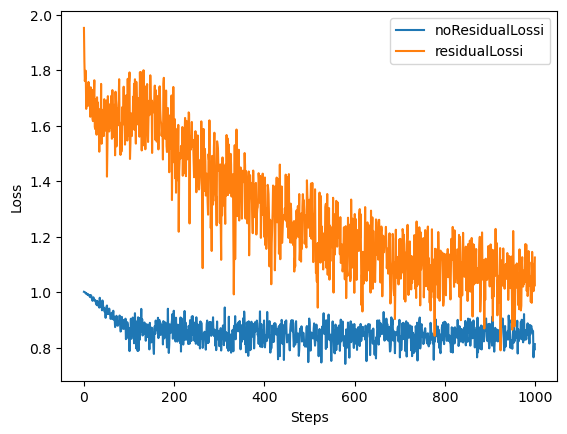

In [ ]:
noResidualLoss = math.exp(noResidualLossi[-1])
residualLoss = math.exp(residualLossi[-1])

print("noResidualLossi", noResidualLoss)
print("residualLossi", residualLoss)

# Plot noResidualLossi and residualLossi
plt.plot(noResidualLossi, label="noResidualLossi")
plt.plot(residualLossi, label="residualLossi")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()





---

The provided code outputs a visual comparison of gradient distributions between models with and without residual connections. The gradients in the non-residual model exhibit vanishing trends in all layers except for the highest hidden layer (layer 80), suggesting a difficulty in training the earlier layers. Conversely, the model with residual connections shows stable gradient distributions across all layers, reflecting an effective training signal throughout the network. This stability indicates that residual connections help maintain consistent learning across all network depths, preventing the vanishing gradient problem and potentially leading to better training outcomes.

---

Model: No Residual Connections
   Average Lower 25% range: -1.92e-07 to -6.39e-09
   Average Upper 25% range: 6.62e-09 to 2.26e-07
   All Lower 25% ranges: [(-1.7094009e-12, -8.481864875438481e-14), (-3.1839058e-12, -1.9058763763143624e-13), (-1.6969754e-11, -7.71561078373971e-13), (-9.344441e-11, -3.784785635937982e-12), (-5.530542e-10, -1.8901162319312492e-11), (-2.6576488e-09, -9.626911767757207e-11), (-1.953722e-08, -5.731290719790394e-10), (-1.2499954e-07, -3.5284956623193864e-09), (-1.5811108e-06, -5.3279597622690744e-08)]
   All Upper 25% ranges: [(8.509026172738316e-14, 1.5507302e-12), (1.8589981171188846e-13, 3.7583855e-12), (7.432333150618128e-13, 2.0163843e-11), (3.634340441441286e-12, 1.1511894e-10), (1.964555341321672e-11, 5.3524507e-10), (9.968690629913457e-11, 2.868586e-09), (5.566421074076899e-10, 2.4013694e-08), (3.485021382587661e-09, 1.6634266e-07), (5.5442825441787136e-08, 1.8414789e-06)]
Model: With Residual Connections
   Average Lower 25% range: -2.08e-03 to -2.7

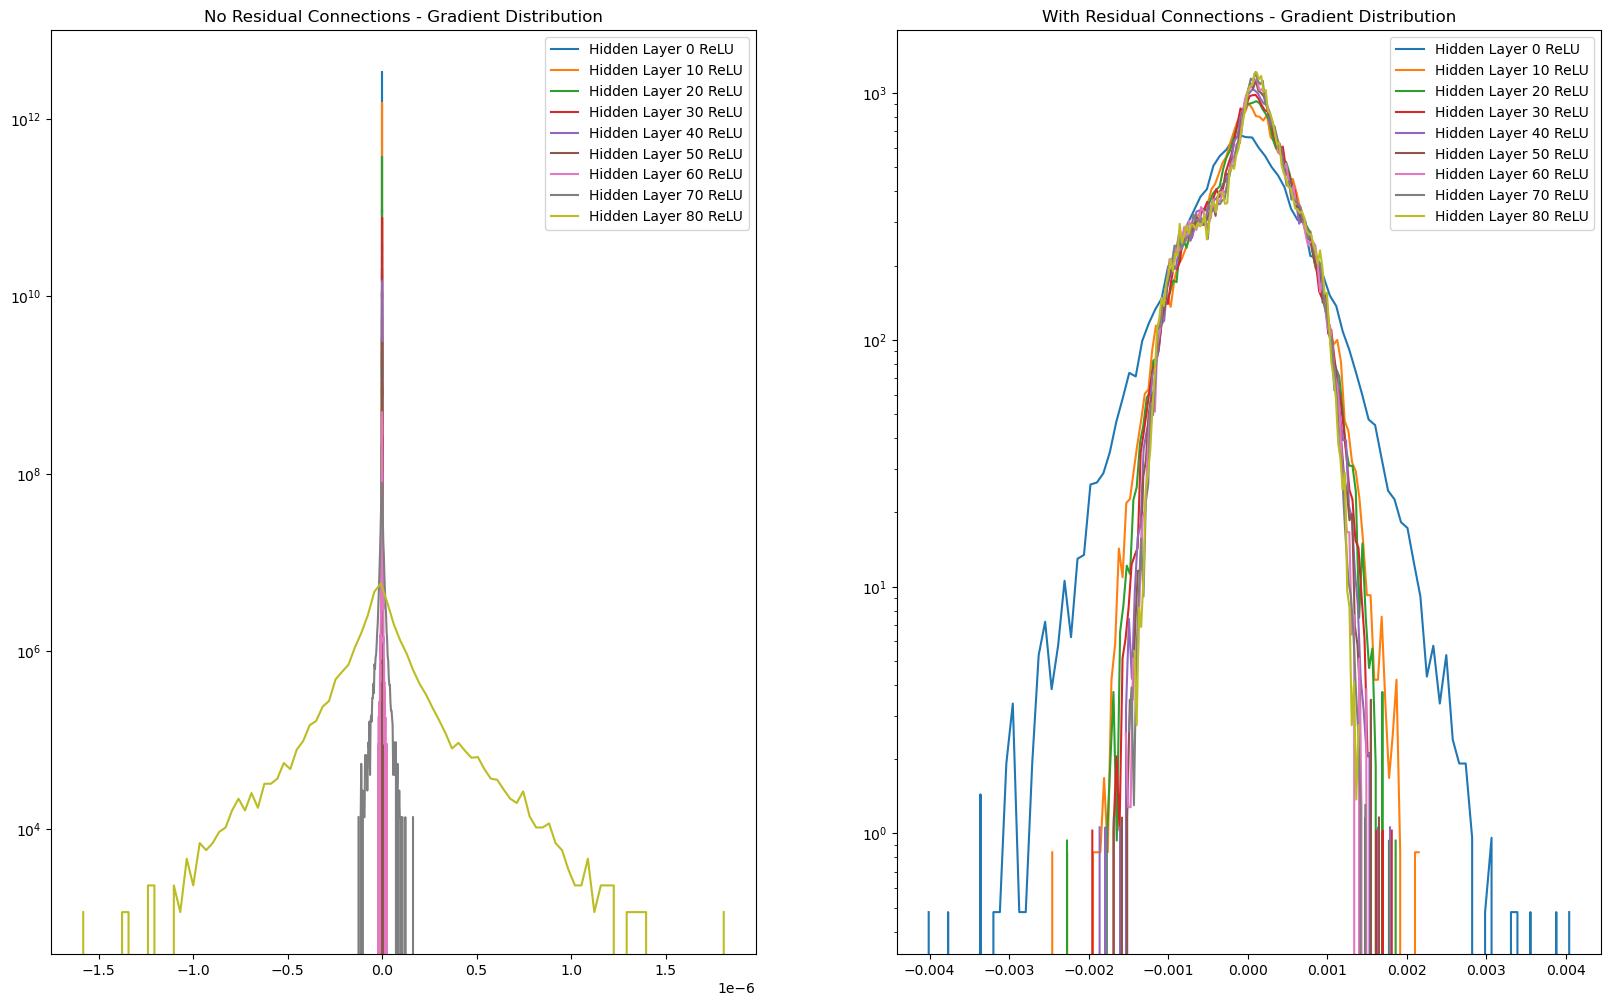

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch


plt.figure(figsize=(20, 12))  # Increased figure size for better visibility

# List containing models and their respective titles
models_list = [(noResidualModel, 'No Residual Connections'), (residualModel, 'With Residual Connections')]

# Function to compute statistics
def compute_statistics(tensor):
    """Compute statistics for a tensor."""
    data = tensor.cpu().numpy()
    return {
        "Lower 25%": (data.min(), np.percentile(data, 25)),
        "Upper 25%": (np.percentile(data, 75), data.max()),
    }

# Subplots for each model
for idx, (model, title) in enumerate(models_list):
    lower_25_ranges = []
    upper_25_ranges = []

    plt.subplot(1, 2, idx + 1)  # Adjusted for two models
    legends = []

    for i, hidden_layer in enumerate(model.hidden_layers):
        for j, layer in enumerate(hidden_layer):
            if isinstance(layer, ReLU) and i in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]:
                if hasattr(layer, 'out'):
                    t = layer.out.grad
                    if t is not None:
                        t = t.cpu()
                        if t is not None:
                            statistics = compute_statistics(t)
                            lower_25_ranges.append(statistics["Lower 25%"])
                            upper_25_ranges.append(statistics["Upper 25%"])

                        hy, hx = torch.histogram(t, density=True)
                        plt.semilogy(hx[:-1].detach(), hy.detach())  # Log scale for Y-axis

                        legends.append(f'Hidden Layer {i} ReLU')

    plt.legend(legends)
    plt.title(f'{title} - Gradient Distribution')

    # Calculate the average ranges
    avg_lower_25_range = np.mean(lower_25_ranges, axis=0)
    avg_upper_25_range = np.mean(upper_25_ranges, axis=0)

    print(f"Model: {title}")
    print(f"   Average Lower 25% range: {avg_lower_25_range[0]:.2e} to {avg_lower_25_range[1]:.2e}")
    print(f"   Average Upper 25% range: {avg_upper_25_range[0]:.2e} to {avg_upper_25_range[1]:.2e}")
    # now we print all lower and upper 25% ranges
    print(f"   All Lower 25% ranges: {lower_25_ranges}")
    print(f"   All Upper 25% ranges: {upper_25_ranges}")
# Save the plot as a PNG file
plt.savefig('gradient_distributionOfResiduals.png')

# Display the plot
plt.show()
